Visualizing circumpolar data
==========
Demo script to show how a circumpolar mesh can be visualized

This example requires the psy-maps plugin and the file ```'G10010_SIBT1850_v1.1._2013-01-15_circumpolar.nc'``` which contains one variable for the sea ice concentration in the arctis. This file is based on Walsh et al., 2015 and has been remapped to a circumpolar grid using Climate Data Operators (CDO, 2015).

In [1]:
import psyplot.project as psy
import matplotlib.colors as mcol
import numpy as np
%matplotlib inline
%config InlineBackend.close_figures = False
# we show the figures after they are drawn or updated. This is useful for the 
# visualization in the ipython notebook
psy.rcParams['auto_show'] = True

Usually, netCDF files contain one-dimensional coordinates, one for the longitude and one for the latitude. Circumpolar grids, however, are defined using 2D coordinates. The visualization using ``psyplot`` is however straight forward.

The file we are plotting here contains a variable for the sea ice concentration (0 - the grid cell contains no ice, 1 - fully ice covered). Therefore we use a colormap that reflects this behaviour. It is white but it's visibility transparency (the alpha value) increases for larger concentration. Furthermore we use a ``'northpole'`` projection (see [Cartopy's projection list](http://scitools.org.uk/cartopy/docs/latest/crs/projections.html#northpolarstereo)) to display it

/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


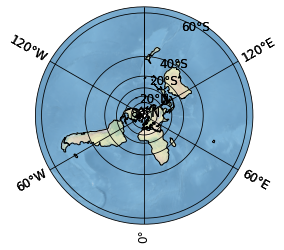

In [2]:
colors = np.ones((100, 4))   # all white
# increase the alpha values from 0 to 1
colors[50:, -1] = np.linspace(0, 1, 50)
colors[:50, -1] = 0
cmap = mcol.LinearSegmentedColormap.from_list('white', colors, 100)
sp = psy.plot.mapplot('G10010_SIBT1850_v1.1._2013-01-15_circumpolar.nc', 
                      projection='northpole', cmap=cmap,
                      # mask all values below 0
                      maskless=0.0,
                      # do not show the colorbar
                      cbar=False,
                      # plot a Natural Earth shaded relief raster on the map
                      stock_img=True)

This plot now shows the entire northern hemisphere. We are however only interested in the arctic, so we adapt our
lonlatbox

/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


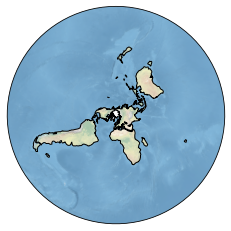

In [3]:
sp.update(lonlatbox=[-180, 180, 60, 90],  # lonmin, lonmax, latmin, latmax
          # disable the grid
          xgrid=False, ygrid=False)

We can also use the ``clon`` and ``clat`` formatoptions to focus on Greenland. Here, we might also want to change the
projection since the *northpole* projection implies ``clat=0``

/home/circleci/miniconda3/envs/docs/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


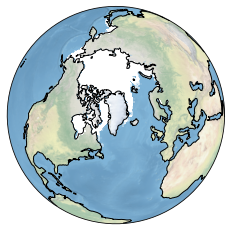

In [4]:
sp.update(clon='Greenland', clat='Greenland', projection='ortho', lonlatbox=None)

Despite the beautiness of these plots, there are a few things to notice when it comes to circumpolar plots

1. Usually, psy-maps interpolates the boundaries for 1D-plots (see the ``interp_bounds`` formatoption), which is
   by default disabled for two-dimensional coordinates
2. As stated above, circumpolar grids have two dimensional coordinates. Those coordinates have to be specified in the
   ``coordinates`` attribute of the visualized netCDF variable (see the [CF Conventions on Alternative Coordinates](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/cf-conventions.html#alternative-coordinates)).
   It is important here that the dataset has not been opened using the `xarray.open_dataset` method, since this will
   delete the `coordinates` attribute. Instead, use the `psyplot.project.open_dataset` function which also interpretes
   the coordinates but does not modify the variable attributes.
3. Unfortunately, the CF-Conventions do not specify the order of the coordinates. So the coordinate attribute could be
   'longitude latitude', 'latitude longitude', 'x y' or 'y x' or anything else. This causes troubles for the
   visualization since we do not know always automatically, what is the x- and what is the y-coordinate (except, the
   `axis` attribute has been specified). If we cannot tell it, we look whether there is a `lon` in the coordinate name
   and if yes, we assume that this is the x-coordinate. If you want to be 100% sure, create the decoder for the
   data array by yourself and give the x- and y-names explicitly
   
   ```python
   from psyplot.data import CFDecoder
   ds = psy.open_dataset('netcdf-file.nc')
   decoder = CFDecoder(x={'x-coordinate-name'}, y={'y-coordinate-name'})
   sp = psy.plot.mapplot(fname, decoder=decoder)
   ```
   For more information, see the [get_x](http://psyplot.readthedocs.io/en/latest/api/psyplot.data.html#psyplot.data.CFDecoder.get_x) and [get_y](http://psyplot.readthedocs.io/en/latest/api/psyplot.data.html#psyplot.data.CFDecoder.get_y) methods of the [CFDecoder](http://psyplot.readthedocs.io/en/latest/api/psyplot.data.html#psyplot.data.CFDecoder) class
   
To sum it all up:
1. by default, circumpolar plots are slightly shifted and the last column and row is not visualized (due to
   matplotlib)
2. Do not use the `xarray.open_dataset` method, it will delete the `coordinates` attribute from the variable
3. Be aware, that a coordinate listed in the `coordinates` meta attribute that contains a `lon` in the name is
   associated with the x-coordinate.


In [5]:
psy.close('all')

### Note
To highlight the differences between `xarray.open_dataset` and `psyplot.project.open_dataset` just look at the
`Attributes` section of the two variables in the variables below

In [6]:
import xarray as xr
print('Opened by xarray.open_dataset')
print(xr.open_dataset('G10010_SIBT1850_v1.1._2013-01-15_circumpolar.nc')['seaice_conc'])
print('Opened by psyplot.project.open_dataset')
print(psy.open_dataset('G10010_SIBT1850_v1.1._2013-01-15_circumpolar.nc')['seaice_conc'])

Opened by xarray.open_dataset
<xarray.DataArray 'seaice_conc' (y: 180, x: 180)>
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)
Coordinates:
    lon      (y, x) float64 ...
    lat      (y, x) float64 ...
Dimensions without coordinates: y, x
Attributes:
    standard_name:  Sea_Ice_Concentration
    long_name:      Sea_Ice_Concentration
    units:          Percent
    short_name:     concentration
Opened by psyplot.project.open_dataset
<xarray.DataArray 'seaice_conc' (y: 180, x: 180)>
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1

References
--------
* CDO 2015: Climate Data Operators.  Available at: http://www.mpimet.mpg.de/cdo
* Walsh, J. E., W. L. Chapman, and F. Fetterer. 2015. Gridded Monthly Sea Ice Extent and Concentration, 1850 Onward,
  Version 1. Boulder, Colorado USA. NSIDC: National Snow and Ice Data Center. doi: http://dx.doi.org/10.7265/N5833PZ5.
  Accessed 26.09.2017.